## Installation

In [1]:
!git clone https://github.com/openai/point-e.git

fatal: destination path 'point-e' already exists and is not an empty directory.


In [2]:
%cd point-e
!ls
!pip install -e .

/content/point-e
LICENSE   model-card.md  point_e	   point_e_model_cache	setup.py  test.png
mesh.ply  new.npz	 point_e.egg-info  README.md		test.jpg
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-o_ui1zx0/clip_63848e0314d741f2bc418804c090e128
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-o_ui1zx0/clip_63848e0314d741f2bc418804c090e128
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Attempting uninstall: point-e
    Found existing installation: point-e 0.0.0
    Uninstalling point-e-0.0.0:
      Successfully uninstalled point-e-0.0.0
  Running setup.py develop for point-e


## Generate Image using sdxl turbo

In [3]:
!pip install diffusers transformers accelerate rembg Pillow --upgrade

  Using cached Pillow-10.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)


In [4]:
%%time
from diffusers import AutoPipelineForText2Image
import torch

## Create Pipeline
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")

prompt = "A photo of a blue water bottle standing on a white background"

image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 12.2 s, sys: 3.59 s, total: 15.8 s
Wall time: 55.8 s


In [5]:
image.save('test.jpg')

In [6]:
from rembg import remove
from PIL import Image

input = Image.open('test.jpg')
output = remove(input)
output.save('test.png')

In [7]:
new_image = Image.new("RGBA", Image.open('test.png').size, "WHITE") # Create a white rgba background
new_image.paste(Image.open('test.png'), (0, 0), Image.open('test.png'))              # Paste the image on the background. Go to the links given below for details.
new_image.convert('RGB').save('test.jpg', "JPEG")  # Save as JPEG

## Image to point cloud

In [8]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base300M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [10]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [11]:
# Load an image to condition on.
# The model accepts only *.jpg
!ls
img = Image.open("test.jpg")

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

LICENSE   model-card.md  point_e	   point_e_model_cache	setup.py  test.png
mesh.ply  new.npz	 point_e.egg-info  README.md		test.jpg


0it [00:00, ?it/s]

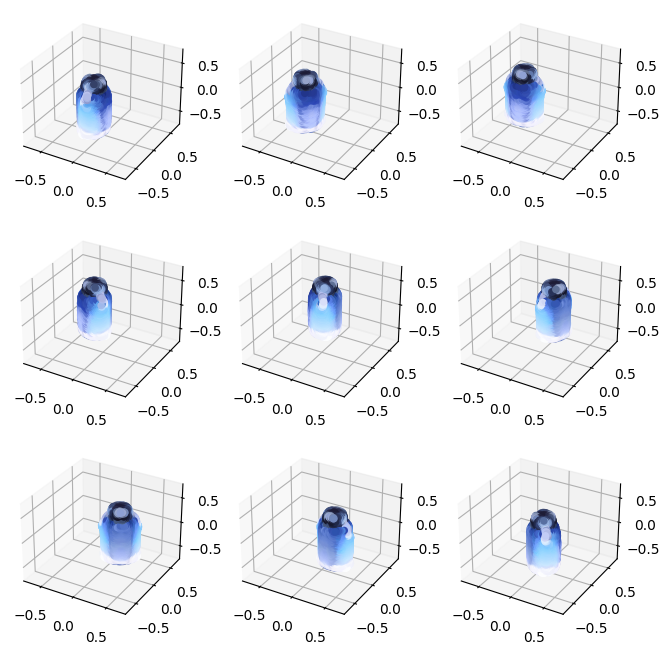

In [12]:
pc = sampler.output_to_point_clouds(samples)[0]
pc.save('new.npz')
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

## Generate mesh from point cloud


In [13]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

  0%|          | 0/512 [00:00<?, ?it/s]

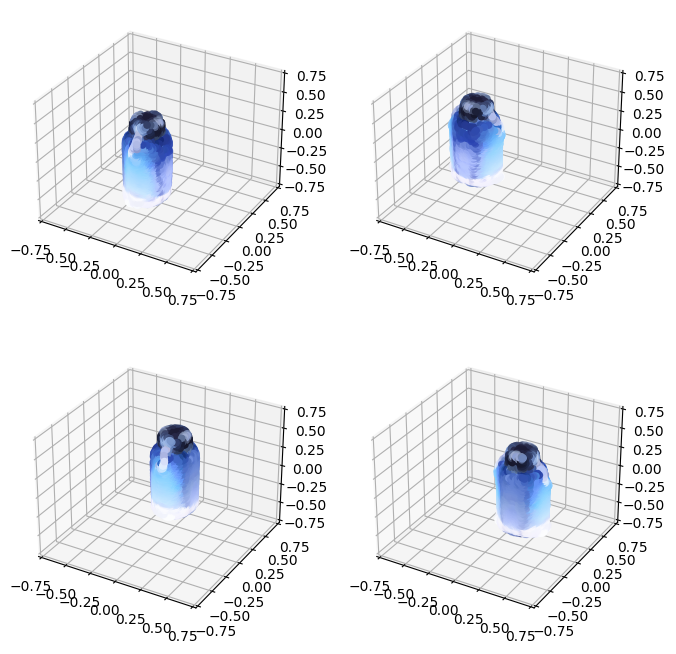

In [14]:
# Load a point cloud we want to convert into a mesh.
pc = PointCloud.load('new.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(pc, grid_size=2)

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

# Write the mesh to a PLY file to import into some other program.
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)

## Fix Mesh


In [1]:
!pip install numpy
!pip install tripy
!pip install plyfile


ValueError: ignored